In [4]:
!pip install gseapy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 12.6 MB/s eta 0:00:00


In [2]:
!pip install matplotlib-venn upsetplot


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45388 sha256=0b18767577d0f5056faf360306c06fad23a3bea99a77bb2eb9ef876f16fbd82d
  Stored in directory: /Users/yangqingdi/Library/Caches/pip/wheels/c2/47/0c/f014c55a1cfd56dce41a1cafd23e3c590652b5e71330cc181c
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24864 sha256=a9378235c0083d3ec560bfe8d1c864a2f204d628e4246d08aa5ccffea7444b8e
  Stored in directory: /Users/yangqingdi/Library/Caches/pip/wheels/5d/7a/54/1460364da0fe4e17c256b7a28191fa373d81292fcf73a4ddb8
Successfully built matplotlib-venn upsetplot


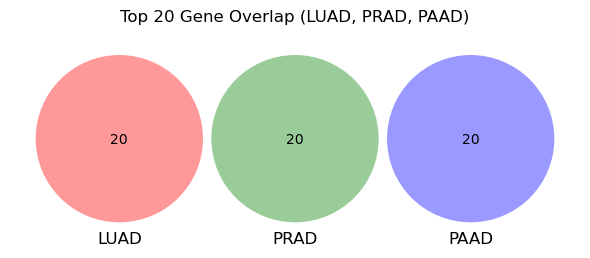

/Applications/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Applications/anaconda3/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

<Figure size 1000x600 with 0 Axes>

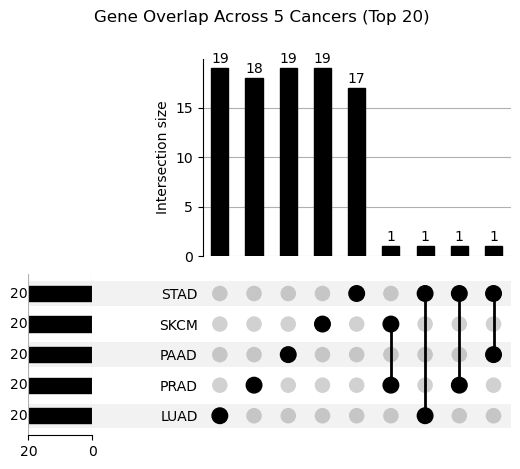

Genes appearing in ≥2 cancers (Top 20 lists):
['Gene_MSRB3', 'Gene_RBMS3', 'Gene_MAGI2-AS3', 'Gene_BOC']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from upsetplot import UpSet
from collections import defaultdict

# ========================
# 1. Load five files
# ========================
file_paths = {
    "LUAD": "/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/LUAD_Random_Forest_Gene_Importance.csv",
    "PRAD": "/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/PRAD_Random_Forest_Gene_Importance.csv",
    "PAAD": "/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/PAAD_Random_Forest_Gene_Importance.csv",
    "SKCM": "/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/SKCM_Random_Forest_Gene_Importance.csv",
    "STAD": "/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/STAD_Random_Forest_Gene_Importance.csv"
}

top_genes_dict = {}

for cancer, path in file_paths.items():
    df = pd.read_csv(path)
    df.columns = [col.strip() for col in df.columns]
    top_genes = df.sort_values(by="Importance", ascending=False).head(20)["Feature"].tolist()
    top_genes_dict[cancer] = top_genes

# ========================
# 2. Venn plot (Select 3 types of cancer)
# ========================
plt.figure(figsize=(6, 5))
venn3([
    set(top_genes_dict["LUAD"]),
    set(top_genes_dict["PRAD"]),
    set(top_genes_dict["PAAD"])
], set_labels=("LUAD", "PRAD", "PAAD"))
plt.title("Top 20 Gene Overlap (LUAD, PRAD, PAAD)")
plt.tight_layout()
plt.show()

# ========================
# 3. UpSet Plot (Suitable for showing the intersection structure of five cancer types)
# ========================
# Build a dictionary of {gene: Which cancers does it appear in}
gene_to_cancer = defaultdict(set)
for cancer, genes in top_genes_dict.items():
    for gene in genes:
        gene_to_cancer[gene].add(cancer)

# Convert to a DataFrame suitable for UpSetPlot
all_cancers = list(file_paths.keys())
records = []
for gene, cancers in gene_to_cancer.items():
    row = {cancer: int(cancer in cancers) for cancer in all_cancers}
    row["gene"] = gene
    records.append(row)

upset_df = pd.DataFrame(records).set_index(all_cancers)


plt.figure(figsize=(10, 6))
upset = UpSet(upset_df, subset_size='count', show_counts=True)
upset.plot()
plt.suptitle("Gene Overlap Across 5 Cancers (Top 20)")
plt.show()

# ========================
# 4. Derive the recurring genes
# ========================
# Genes that occur in two or more types of cancer
overlapping_genes = [gene for gene, cancers in gene_to_cancer.items() if len(cancers) >= 2]
print("Genes appearing in ≥2 cancers (Top 20 lists):")
print(overlapping_genes)


pd.Series(overlapping_genes).to_csv("Shared_Genes_MoreThan2Cancers.csv", index=False)


In [ ]:
import gseapy as gp

# Common genes (top20 genes occurring in ≥2 cancer types)
shared_genes = ['Gene_MSRB3', 'Gene_RBMS3', 'Gene_MAGI2-AS3', 'Gene_BOC']
gene_list = [g.replace("Gene_", "") for g in shared_genes]

# GO Biological Process + KEGG 
enrichr_result = gp.enrichr(
    gene_list=gene_list,
    gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
    organism='Human',
    outdir=None,
    cutoff=0.5  
)

# Output the KEGG result
kegg_df = enrichr_result.results[
    enrichr_result.results["Gene_set"] == "KEGG_2021_Human"
][["Term", "Adjusted P-value", "Overlap", "Genes"]]


print(kegg_df.head())


                          Term  Adjusted P-value Overlap Genes
16  Hedgehog signaling pathway          0.022308    1/56   BOC
17               Axon guidance          0.035909   1/182   BOC


In [ ]:
import gseapy as gp

# Clean the list of the top 20 genes of 5 cancer types (remove the prefixes)
cleaned_top20_dict = {
    cancer: [gene.replace("Gene_", "") for gene in genes]
    for cancer, genes in top_genes_dict.items()
}

# KEGG enrichment analysis was performed for each cancer type
enrichment_results = {}

for cancer, gene_list in cleaned_top20_dict.items():
    try:
        enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets=['KEGG_2021_Human'],
            organism='Human',
            outdir=None,
            cutoff=0.05
        )
        result_df = enr.results
        result_df = result_df[result_df["Gene_set"] == "KEGG_2021_Human"]
        result_df["Cancer"] = cancer
        enrichment_results[cancer] = result_df[["Term", "Adjusted P-value", "Overlap", "Genes", "Cancer"]]
    except Exception as e:
        print(f"Enrichment failed for {cancer}: {e}")

# Combine the results of all cancer types
all_kegg_df = pd.concat(enrichment_results.values(), ignore_index=True)

all_kegg_df.head(10) 
all_kegg_df.to_csv("/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/KEGG_Enrichment_by_Cancer.csv", index=False)



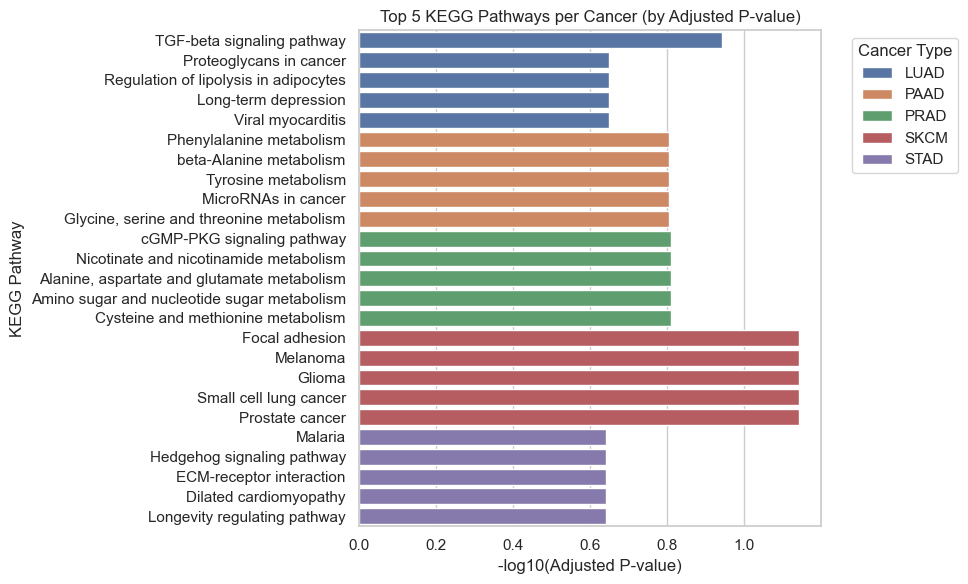

In [ ]:
##Generate a graph of the top5 pathways for each cancer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Only the top 5 pathways with the smallest Adjusted P-value for each cancer type are retained
top5_per_cancer = all_kegg_df.sort_values(by=["Cancer", "Adjusted P-value"]).groupby("Cancer").head(5)


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Add the -log10(P value) column for visualization
top5_per_cancer["-log10(padj)"] = -np.log10(top5_per_cancer["Adjusted P-value"])

# Draw a bar chart
sns.barplot(
    data=top5_per_cancer,
    y="Term",
    x="-log10(padj)",
    hue="Cancer"
)

plt.title("Top 5 KEGG Pathways per Cancer (by Adjusted P-value)")
plt.xlabel("-log10(Adjusted P-value)")
plt.ylabel("KEGG Pathway")
plt.legend(title="Cancer Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
#Count whether the same pathways have emerged in multiple types of cancer
# Check in which types of cancer each pathway occurs
pathway_cancer_map = all_kegg_df.groupby("Term")["Cancer"].unique().reset_index()

# Add a column: The number of cancer types that occur
pathway_cancer_map["Cancer_Count"] = pathway_cancer_map["Cancer"].apply(len)

# Screen for pathways that occur in two or more cancer types (i.e., those with commonalities)
shared_pathways = pathway_cancer_map[pathway_cancer_map["Cancer_Count"] >= 2]

# Show common pathways
shared_pathways[["Term", "Cancer", "Cancer_Count"]]


,Term,Cancer,Cancer_Count
10,Apelin signaling pathway,"[PAAD, STAD]",2
13,Autophagy,"[PAAD, SKCM]",2
14,Axon guidance,"[PAAD, SKCM, STAD]",3
18,Breast cancer,"[LUAD, SKCM]",2
19,C-type lectin receptor signaling pathway,"[PAAD, SKCM]",2
20,Calcium signaling pathway,"[LUAD, PRAD, SKCM, STAD]",4
22,Cellular senescence,"[PAAD, SKCM]",2
25,Chemical carcinogenesis,"[LUAD, SKCM]",2
35,Diabetic cardiomyopathy,"[PRAD, SKCM, STAD]",3
36,Dilated cardiomyopathy,"[LUAD, STAD]",2


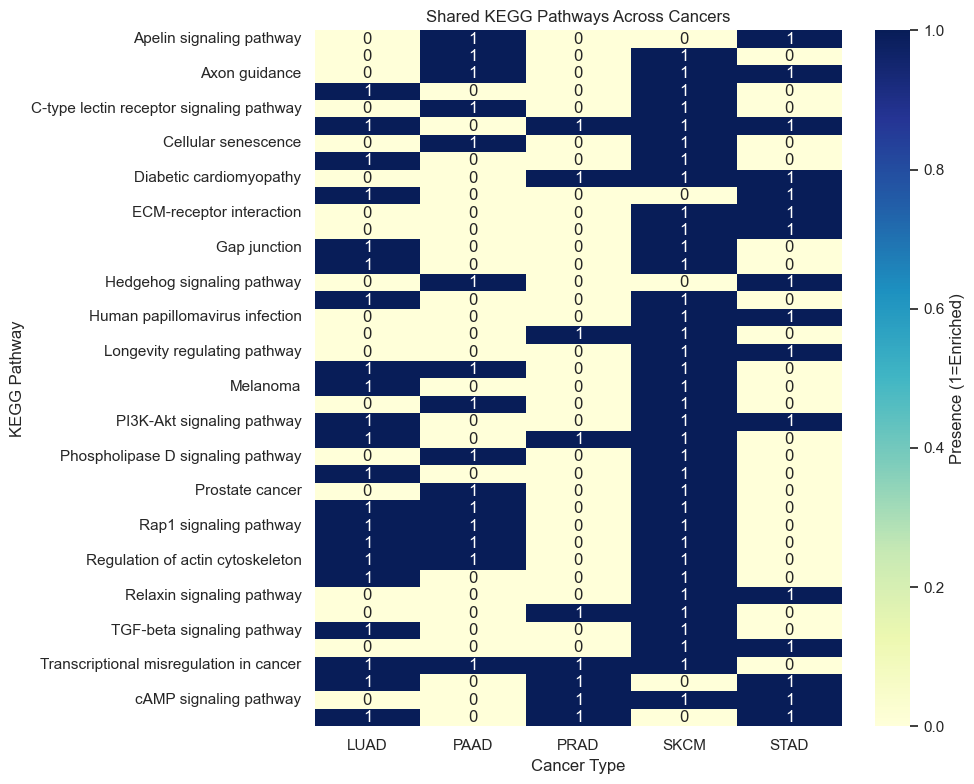

In [ ]:
## Generate the presence matrix and heat map of pathways - cancer types
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the presence matrix of pathways - cancer types
presence_matrix = pd.crosstab(all_kegg_df["Term"], all_kegg_df["Cancer"])
presence_matrix = presence_matrix.loc[presence_matrix.sum(axis=1) >= 2]  


presence_matrix.to_csv("/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/Shared_KEGG_Pathways_Presence_Matrix.csv")

# Draw a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(presence_matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Presence (1=Enriched)'})
plt.title("Shared KEGG Pathways Across Cancers")
plt.ylabel("KEGG Pathway")
plt.xlabel("Cancer Type")
plt.tight_layout()
plt.show()


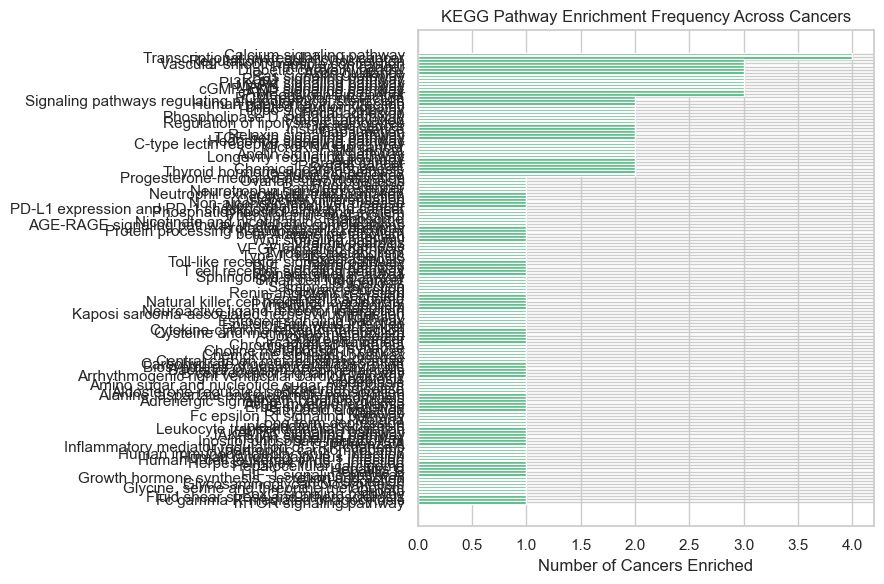

✅ 已保存两个结果文件：
- KEGG_Pathway_Hits_by_Cancer.csv
- KEGG_Pathway_Frequency_Summary.csv


In [ ]:
# KEGG enrichment result file
df = pd.read_csv("/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/KEGG_Enrichment_by_Cancer.csv")

# Mark the genes hit in each pathway (sorted by cancer)
grouped_genes = df.groupby(["Cancer", "Term"])["Genes"].apply(lambda x: ', '.join(x)).reset_index()
grouped_genes.columns = ["Cancer", "KEGG Pathway", "Hit Genes"]

# Summarize how many types of cancer each pathway is hit by
pathway_counts = df.groupby("Term")["Cancer"].nunique().reset_index()
pathway_counts.columns = ["KEGG Pathway", "Cancer Count"]
pathway_counts = pathway_counts.sort_values(by="Cancer Count", ascending=False)

# Visualization occurrence frequency (bar chart)
plt.figure(figsize=(9, 6))
plt.barh(pathway_counts["KEGG Pathway"], pathway_counts["Cancer Count"], color="mediumseagreen")
plt.xlabel("Number of Cancers Enriched")
plt.title("KEGG Pathway Enrichment Frequency Across Cancers")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


grouped_genes.to_csv("/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/KEGG_Pathway_Hits_by_Cancer.csv", index=False)
pathway_counts.to_csv("/Users/yangqingdi/Desktop/M-28/ML_model/Random_Forest/KEGG_Pathway_Frequency_Summary.csv", index=False)
print("：\n- KEGG_Pathway_Hits_by_Cancer.csv\n- KEGG_Pathway_Frequency_Summary.csv")


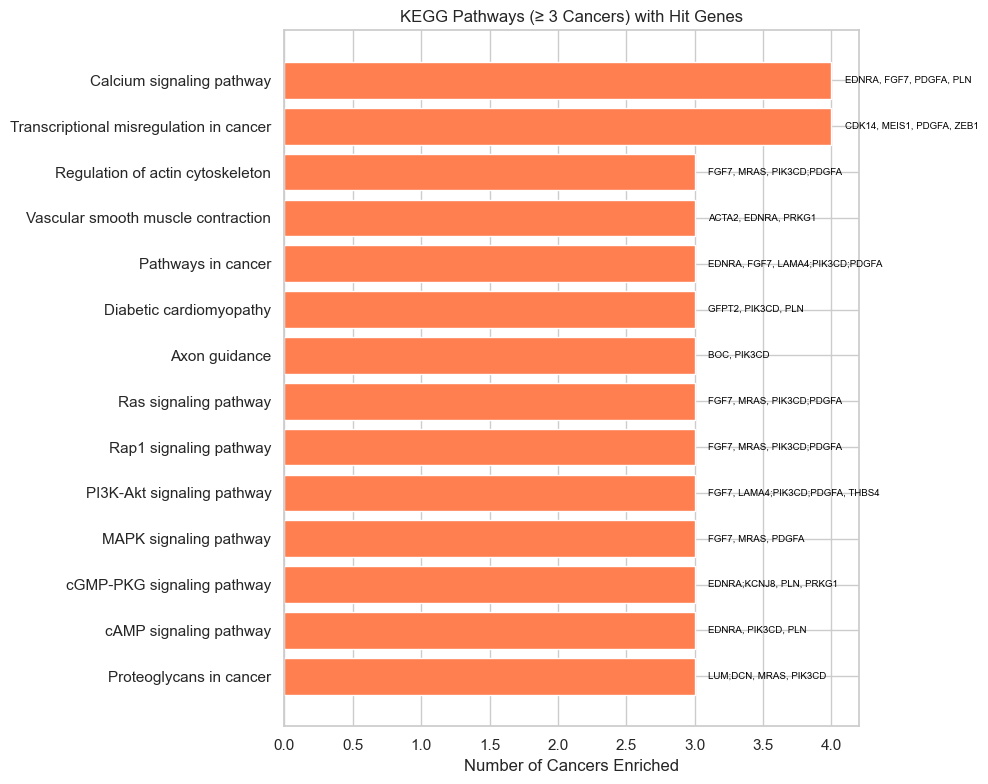

In [ ]:
# Extract the list of pathways that hit the number of cancer types ≥ 3
selected_pathways = set(pathway_counts_filtered["KEGG Pathway"])

# Screen the records corresponding to these pathways (including hit genes) from grouped_genes
filtered_genes_by_pathway = grouped_genes[grouped_genes["KEGG Pathway"].isin(selected_pathways)]

# Combine the hit genes of multiple cancer types in each pathway into one line (after removing duplicates)
gene_summary = filtered_genes_by_pathway.groupby("KEGG Pathway")["Hit Genes"].apply(
    lambda x: ', '.join(sorted(set(', '.join(x).split(', '))))
).reset_index()

# Merge with the previous pathway_counts_filtered and add a column: Hit genes
pathway_with_genes = pd.merge(pathway_counts_filtered, gene_summary, on="KEGG Pathway")

# Visualization, annotated bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(pathway_with_genes["KEGG Pathway"], pathway_with_genes["Cancer Count"], color="coral")
plt.xlabel("Number of Cancers Enriched")
plt.title("KEGG Pathways (≥ 3 Cancers) with Hit Genes")

# Add text annotations (hit genes) to the graph
for bar, genes in zip(bars, pathway_with_genes["Hit Genes"]):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
             genes, va='center', fontsize=7, color='black')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Generate a three-layer structure data frame (cancer type - pathway - gene)
cancer_pathway_gene_df = df[["Cancer", "Term", "Genes"]].copy()
cancer_pathway_gene_df.columns = ["Cancer", "KEGG Pathway", "Hit Genes"]

# Split multiple genes (separated by commas) into multiple lines
cancer_pathway_gene_df["Hit Genes"] = cancer_pathway_gene_df["Hit Genes"].str.split(", ")
expanded_df = cancer_pathway_gene_df.explode("Hit Genes").drop_duplicates()

# Extract high-frequency pathways (hitting ≥ 3 cancer types)
high_freq_terms = pathway_counts_filtered["KEGG Pathway"].tolist()
high_freq_df = expanded_df[expanded_df["KEGG Pathway"].isin(high_freq_terms)]

# Export the three-layer structure of the high-frequency path as CSV
high_freq_df.to_csv("High_Frequency_Pathway_Cancer_Gene_Triplets.csv", index=False)

# Summarize pathway -> occurrence frequency (for PPT form)
ppt_summary = pathway_counts_filtered[["KEGG Pathway", "Cancer Count"]].copy()
ppt_summary.to_csv("KEGG_HighFrequency_Summary_For_PPT.csv", index=False)

# Derive the three-layer structure
high_freq_df.to_csv("High_Frequency_Pathway_Cancer_Gene_Triplets.csv", index=False)

# Export the PPT table
ppt_summary = pathway_counts_filtered[["KEGG Pathway", "Cancer Count"]].copy()
ppt_summary.to_csv("KEGG_HighFrequency_Summary_For_PPT.csv", index=False)



In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the high-frequency three-layer structure table
df = pd.read_csv("High_Frequency_Pathway_Cancer_Gene_Triplets.csv")

# Prepare all the unique nodes
cancers = df["Cancer"].unique().tolist()
pathways = df["KEGG Pathway"].unique().tolist()
genes = df["Hit Genes"].unique().tolist()
nodes = cancers + pathways + genes

# Map the name to the index
node_indices = {name: i for i, name in enumerate(nodes)}

# Cancer -> Pathway
cancer_to_pathway = df[["Cancer", "KEGG Pathway"]].drop_duplicates()
links1 = {
    "source": [node_indices[c] for c in cancer_to_pathway["Cancer"]],
    "target": [node_indices[p] for p in cancer_to_pathway["KEGG Pathway"]],
    "value": [1] * len(cancer_to_pathway)
}

# Pathway -> Gene
pathway_to_gene = df[["KEGG Pathway", "Hit Genes"]].drop_duplicates()
links2 = {
    "source": [node_indices[p] for p in pathway_to_gene["KEGG Pathway"]],
    "target": [node_indices[g] for g in pathway_to_gene["Hit Genes"]],
    "value": [1] * len(pathway_to_gene)
}

# Merge the links in both directions
sankey_links = {
    "source": links1["source"] + links2["source"],
    "target": links1["target"] + links2["target"],
    "value": links1["value"] + links2["value"]
}

# Draw the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightsteelblue"
    ),
    link=dict(
        source=sankey_links["source"],
        target=sankey_links["target"],
        value=sankey_links["value"]
    )
)])

fig.update_layout(title_text="Cancer → Pathway → Gene Sankey Diagram", font_size=10, height=800)
fig.show()
